In [4]:
pip install scikit-learn


  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


Sample data:
   temperature   humidity    rainfall  storage_days  crop_type  loss_percent
0    22.490802  41.107976   52.341137            19          1     74.555308
1    34.014286  62.514057   49.395760            25          1     93.087759
2    29.639879  82.376750  181.250916             5          0     71.179184
3    26.973170  73.933493   49.909240             8          0     65.870673
4    18.120373  78.393669   54.389945             7          0     69.957975


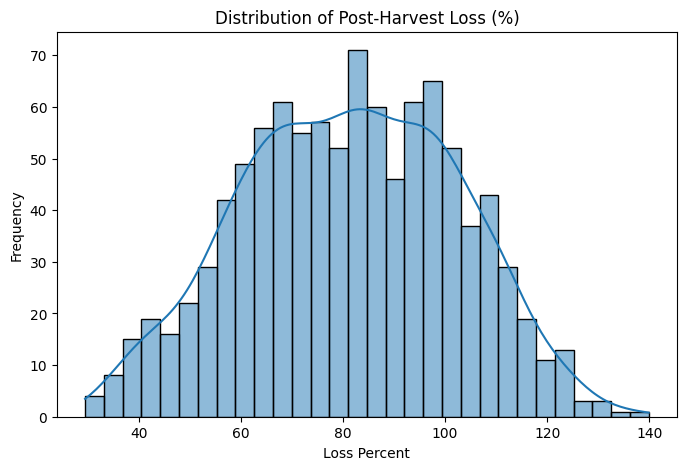

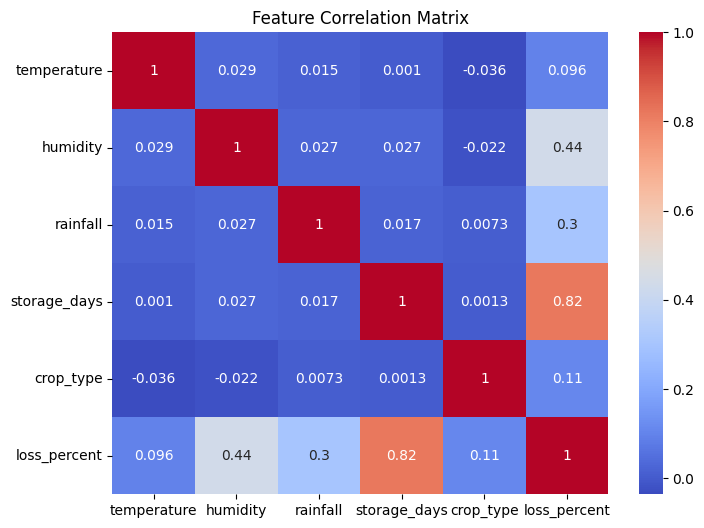

Best alpha: 0.017271869990824557
Best l1_ratio: 1.0
Selected features by ElasticNet:
  temperature: 1.7448
  humidity: 8.5579
  rainfall: 5.7845
  storage_days: 16.9195
  crop_type: 2.4432
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Evaluation on Test Set:
  Mean Absolute Error (MAE): 4.49
  Root Mean Squared Error (RMSE): 5.91
  R^2 Score: 0.93


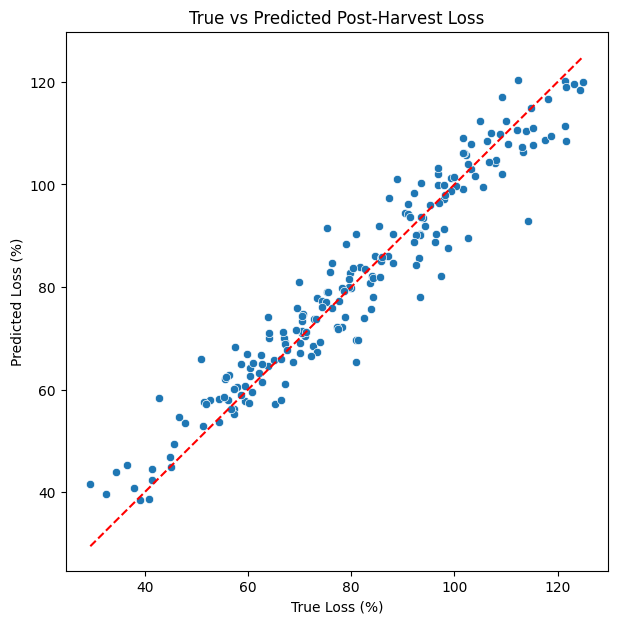

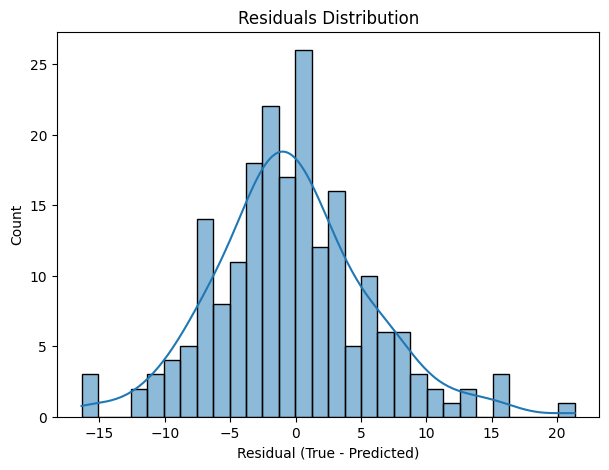

Predicted post-harvest loss (%) for new sample: 72.39


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Step 1: Generate Synthetic Dataset
# -------------------------------

np.random.seed(42)
n_samples = 1000

data = pd.DataFrame({
    'temperature': np.random.uniform(15, 35, n_samples),   # °C
    'humidity': np.random.uniform(30, 90, n_samples),      # %
    'rainfall': np.random.uniform(0, 200, n_samples),      # mm
    'storage_days': np.random.randint(1, 30, n_samples),   # days in storage
    'crop_type': np.random.choice([0, 1], n_samples),      # 0=wheat, 1=maize
})

# Simulate post-harvest loss (%) with noise
data['loss_percent'] = (
    0.3 * data['temperature'] +
    0.5 * data['humidity'] +
    0.1 * data['rainfall'] +
    2.0 * data['storage_days'] +
    5 * data['crop_type'] +
    np.random.normal(0, 5, n_samples)  # Noise
)

print("Sample data:")
print(data.head())

# -------------------------------
# Step 2: Exploratory Data Analysis (EDA)
# -------------------------------

# Visualize distribution of loss_percent
plt.figure(figsize=(8, 5))
sns.histplot(data['loss_percent'], bins=30, kde=True)
plt.title('Distribution of Post-Harvest Loss (%)')
plt.xlabel('Loss Percent')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# -------------------------------
# Step 3: Feature Selection using ElasticNet (Sparse Learning)
# -------------------------------

X = data.drop(columns=['loss_percent'])
y = data['loss_percent']

# Standardize features for ElasticNet
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ElasticNet with cross-validation to find best alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV

elastic_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=42)
elastic_net_cv.fit(X_scaled, y)

print(f"Best alpha: {elastic_net_cv.alpha_}")
print(f"Best l1_ratio: {elastic_net_cv.l1_ratio_}")

# Coefficients of features
coef = elastic_net_cv.coef_
feature_names = X.columns
selected_features = feature_names[coef != 0]

print("Selected features by ElasticNet:")
for feat, weight in zip(feature_names, coef):
    print(f"  {feat}: {weight:.4f}")

# Reduce X to selected features
X_selected = pd.DataFrame(X_scaled, columns=feature_names)[selected_features]

# -------------------------------
# Step 4: Train-Test Split
# -------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# -------------------------------
# Step 5: Model Training - Random Forest Regressor
# -------------------------------

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# Train best estimator on full training set
best_rf = grid_search.best_estimator_

# -------------------------------
# Step 6: Model Evaluation
# -------------------------------

y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Evaluation on Test Set:")
print(f"  Mean Absolute Error (MAE): {mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  R^2 Score: {r2:.2f}")

# Plot true vs predicted loss
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Loss (%)")
plt.ylabel("Predicted Loss (%)")
plt.title("True vs Predicted Post-Harvest Loss")
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.show()

# -------------------------------
# Step 7: Prediction on New Data
# -------------------------------

# Example new data (raw)
new_sample_raw = pd.DataFrame({
    'temperature': [28],
    'humidity': [70],
    'rainfall': [50],
    'storage_days': [10],
    'crop_type': [1]
})

# Preprocess: scale and select features
new_sample_scaled = scaler.transform(new_sample_raw)
new_sample_selected = pd.DataFrame(new_sample_scaled, columns=feature_names)[selected_features]

# Predict loss
predicted_loss = best_rf.predict(new_sample_selected)[0]
print(f"Predicted post-harvest loss (%) for new sample: {predicted_loss:.2f}")



In [6]:
###Save the model, scaler and selectwede features 

import joblib
import os

# Create directory if it doesn't exist
os.makedirs('model_files', exist_ok=True)

# Save the trained Random Forest model
joblib.dump(best_rf, 'model_files/best_rf.pkl')

# Save the scaler used for feature scaling
joblib.dump(scaler, 'model_files/scaler.pkl')

# Save the selected features (as a list)
joblib.dump(list(selected_features), 'model_files/selected_features.pkl')

print("Model, scaler, and selected features saved successfully in 'model_files/' folder.")

Model, scaler, and selected features saved successfully in 'model_files/' folder.


In [8]:
# Loading saved objects example
loaded_model = joblib.load('model_files/best_rf.pkl')
loaded_scaler = joblib.load('model_files/scaler.pkl')
loaded_features = joblib.load('model_files/selected_features.pkl')

print("Loaded features:", loaded_features)


Loaded features: ['temperature', 'humidity', 'rainfall', 'storage_days', 'crop_type']
